In [22]:
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
from sklearn.metrics import confusion_matrix
from util.dataset import get_dataset
from util.util import add_noise
import matplotlib.pyplot as plt
import argparse
import numpy as np

In [25]:
parser = argparse.ArgumentParser()  
parser.add_argument('--dataset', type=str, default='cifar10', help="name of dataset")
parser.add_argument('--level_n_system', type=float, default=0.4, help="fraction of noisy clients")
parser.add_argument('--level_n_lowerb', type=float, default=0.5, help="lower bound of noise level")
parser.add_argument('--seed', type=int, default=13, help="random seed, default: 1")
parser.add_argument('--iid', action='store_false', help="i.i.d. or non-i.i.d.")
parser.add_argument('--num_users', type=int, default=100, help="number of uses: K")
args = parser.parse_args(args=[])

In [26]:
dataset_train, dataset_test, dict_users = get_dataset(args)

# ---------------------Add Noise ---------------------------
y_train = np.array(dataset_train.targets)
y_train_noisy, gamma_s, real_noise_level = add_noise(args, y_train, dict_users)


Files already downloaded and verified
Files already downloaded and verified
Client 0, noise level: 0.8484 (0.7635), real noise ratio: 0.7540
Client 2, noise level: 0.6389 (0.5750), real noise ratio: 0.5820
Client 3, noise level: 0.6168 (0.5551), real noise ratio: 0.5520
Client 4, noise level: 0.9228 (0.8306), real noise ratio: 0.8120
Client 6, noise level: 0.8445 (0.7600), real noise ratio: 0.7740
Client 7, noise level: 0.5767 (0.5191), real noise ratio: 0.5220
Client 8, noise level: 0.6018 (0.5416), real noise ratio: 0.5440
Client 9, noise level: 0.5338 (0.4804), real noise ratio: 0.4720
Client 13, noise level: 0.6124 (0.5512), real noise ratio: 0.5620
Client 15, noise level: 0.5169 (0.4652), real noise ratio: 0.4560
Client 20, noise level: 0.8059 (0.7253), real noise ratio: 0.6720
Client 23, noise level: 0.6870 (0.6183), real noise ratio: 0.6240
Client 26, noise level: 0.9083 (0.8175), real noise ratio: 0.8260
Client 27, noise level: 0.5399 (0.4859), real noise ratio: 0.5340
Client 2

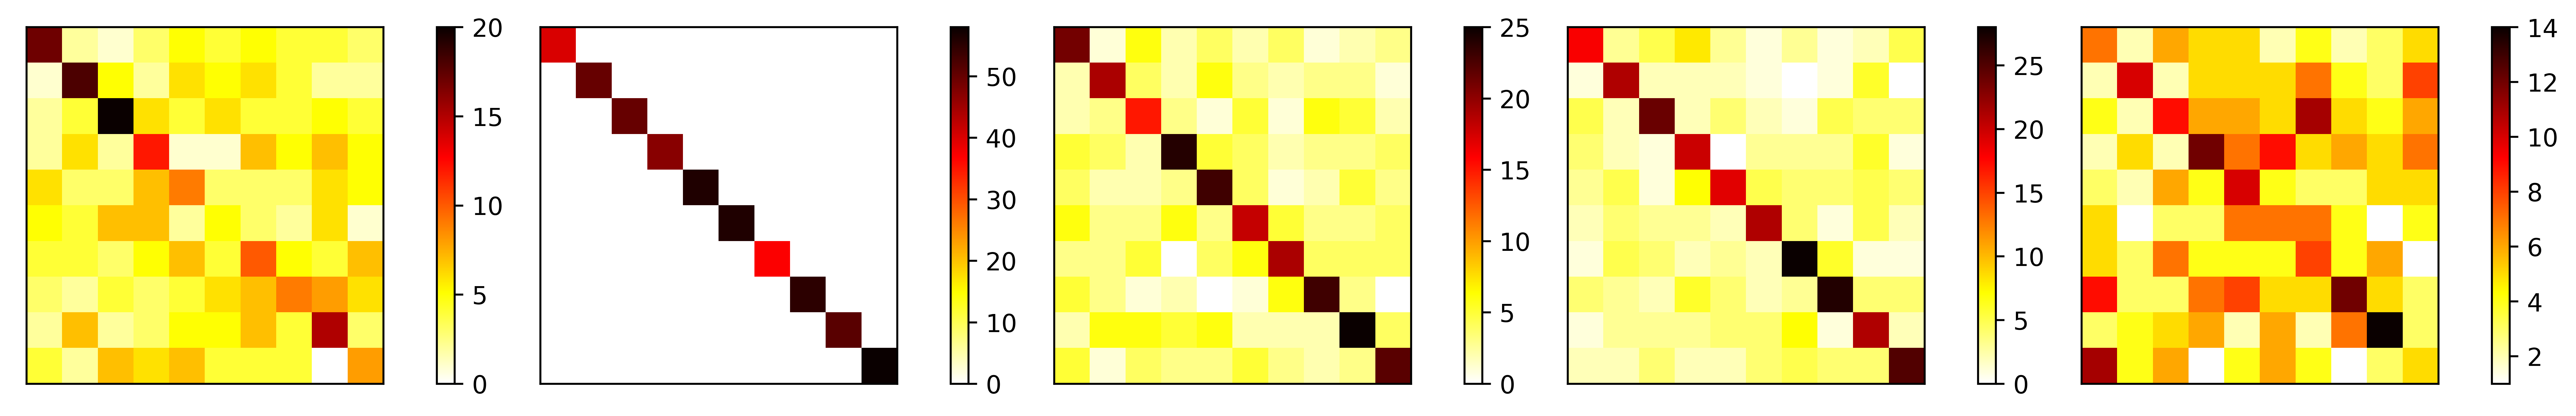

In [28]:
# plot confusion matrix (take the first 5 clients for example)
fig, axes = plt.subplots(1, 5, sharex=False,sharey=True, figsize=(18, 3), dpi=600)

for i, ax in enumerate(axes):
    idx = list(dict_users[i])
    y_true = y_train[idx]
    y_noisy = y_train_noisy[idx]
    conf_matrix = confusion_matrix(y_true, y_noisy)
    im = ax.imshow(conf_matrix, cmap=plt.cm.hot_r)
    ax.set_yticks([])
    ax.set_xticks([])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.3)
    plt.colorbar(im, cax=cax)
plt.show()

#Below is code to plot the non-IID data distribution as shown in the README.md file

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms

In [5]:
def non_iid_dirichlet_sampling(y_train, num_classes, p, num_users, seed, alpha_dirichlet=100):
    np.random.seed(seed)
    Phi = np.random.binomial(1, p, size=(num_users, num_classes))  # indicate the classes chosen by each client
    n_classes_per_client = np.sum(Phi, axis=1)
    while np.min(n_classes_per_client) == 0:
        invalid_idx = np.where(n_classes_per_client==0)[0]
        Phi[invalid_idx] = np.random.binomial(1, p, size=(len(invalid_idx), num_classes))
        n_classes_per_client = np.sum(Phi, axis=1)
    Psi = [list(np.where(Phi[:, j]==1)[0]) for j in range(num_classes)]   # indicate the clients that choose each class
    num_clients_per_class = np.array([len(x) for x in Psi])
    dict_users = {}
    for class_i in range(num_classes):
        all_idxs = np.where(y_train==class_i)[0]
        p_dirichlet = np.random.dirichlet([alpha_dirichlet] * num_clients_per_class[class_i])
        assignment = np.random.choice(Psi[class_i], size=len(all_idxs), p=p_dirichlet.tolist())

        for client_k in Psi[class_i]:
            if client_k in dict_users:
                dict_users[client_k] = set(dict_users[client_k] | set(all_idxs[(assignment == client_k)]))
            else:
                dict_users[client_k] = set(all_idxs[(assignment == client_k)]) 
    
    return dict_users, np.array([[np.sum(y_train[list(dict_users[i])]==j) for j in range(10)] for i in range(100)])

dataset = 'cifar10'
data_path = '~/Desktop/datasets/cifar10'#'your_cifar10_datapath' #'~/Desktop/datasets/cifar10'
num_classes = 10
model = 'resnet18'
trans_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])],
)
trans_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])],
)
dataset_train = datasets.CIFAR10(data_path, train=True, download=True, transform=trans_train)
dataset_test = datasets.CIFAR10(data_path, train=False, download=True, transform=trans_val)
n_train = len(dataset_train)
y_train = np.array(dataset_train.targets)
alpha = 10
p = 0.7
dict_users, mat = non_iid_dirichlet_sampling(y_train, 10, p, 100, 13, alpha)
dict_users2, mat2 = non_iid_dirichlet_sampling(y_train, 10, 0.7, 100, 13, 1)
dict_users3, mat3 = non_iid_dirichlet_sampling(y_train, 10, 0.3, 100, 13, 10)
#print(mat)


Files already downloaded and verified
Files already downloaded and verified


In [6]:
b=sorted(mat, key=lambda x: sum(x), reverse=True)
b=np.array(b)
b2=sorted(mat2, key=lambda x: sum(x), reverse=True)
b2=np.array(b2)
b3=sorted(mat3, key=lambda x: sum(x), reverse=True)
b3=np.array(b3)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


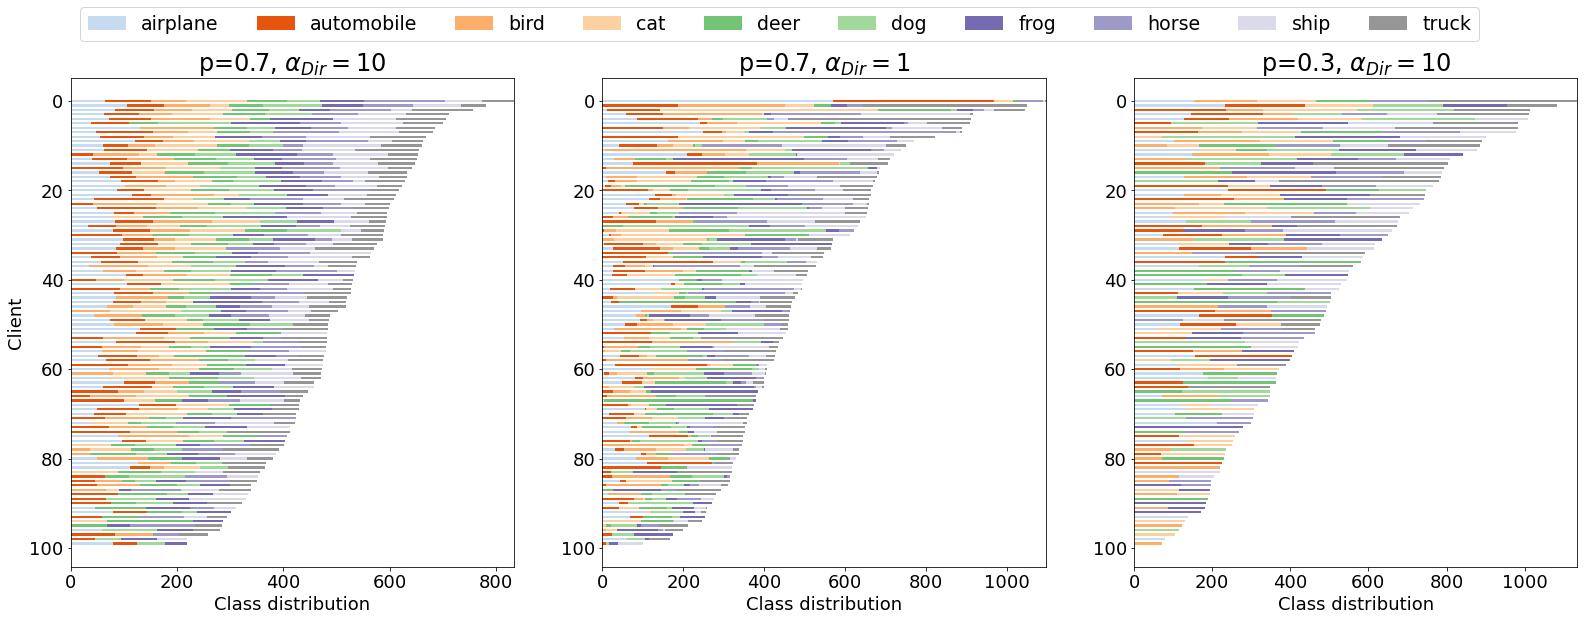

In [7]:
import matplotlib
def survey2(results,b2,b3, category_names):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    title = [r'p=0.7, $\alpha_{Dir}=10$', r'p=0.7, $\alpha_{Dir}=1$', r'p=0.3, $\alpha_{Dir}=10$']
    labels = [i for i in range(100)]
    data= results
    data_cum = data.cumsum(axis=1)
    category_colors = plt.get_cmap('tab20c')(  #tab20c
        np.linspace(0.15, 0.85, data.shape[1]))   # RdYlGn 0.15, 0.85

    fig, axes = plt.subplots(1,3,figsize=(29, 9))
    b_list= [results,b2,b3]
    for j,ax in enumerate(axes):
        data_cum=b_list[j].cumsum(axis=1)
        data = b_list[j]
        ax.invert_yaxis()
        ax.xaxis.set_visible(True)
        ax.set_xlim(0, np.sum(data, axis=1).max())
        #ax.set_ylim(101, 1)
        ax.set_title(title[j], fontsize=24)
        if j == 0:
            ax.set_ylabel("Client", fontsize=18)
        ax.set_xlabel("Class distribution", fontsize=18)
        ax.tick_params( labelsize= 18)

        for i, (colname, color) in enumerate(zip(category_names, category_colors)):
            widths = data[:, i]
            starts = data_cum[:, i] - widths
            rects = ax.barh(labels, widths, left=starts, height=0.5,
                            label=colname, color=color)
            
        if j == 0:
            ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1.055),
                    loc='lower left', fontsize=19)
    return fig, ax


category_names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

survey2(b,b2,b3, category_names)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(27, 9)
plt.savefig('noniid_stat.eps', dpi=600)

# plt.show()